<a href="https://colab.research.google.com/github/sudarshansivakumar/MIDAS-IIITD-Flipkart/blob/main/Flipkart_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Importing the necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import re
import nltk
import spacy
import string
from torch.utils.data import dataloader
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchtext.legacy import data
import torch.nn as nn
import torch.nn.functional as F



#### **Importing the dataset using the path where it is stored**
To replicate result, write *dataset_path = '**Local path of dataset**'*

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/Copy of flipkart_com-ecommerce_sample.csv"
flipkart_dataset = pd.read_csv(dataset_path)

#### **Looking at the data**

In [ ]:
# First we increase the default column width in pandas in order to make sure that the prouct category tree column is printed completely 

pd.options.display.max_colwidth = 300

#We now print the product category tree and the product description for the first 10 rows of data
flipkart_dataset.head()

NameError: ignored

In [ ]:
print(f"Number of columns : {len(flipkart_dataset.columns)}")
print(flipkart_dataset.columns)


Number of columns : 15
Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')


### **Preprocessing Data**

#### Dropping columns that are irrelevent to the final answer 
* The unique id's are alloted randomly for all products so we don't need to consider them 
* The crawl time stamp similarly does not indicate the category of the product it only talks about when the data was scraped 
* product_url contains the product name and ID, which could be useful for predicting category but it is redundant to keep this information twice 
* retail_price does not indicate the product category well. While certain categories might be costlier than others, the prices are still too randomly scattered to be considered important for category prediction 
* discounted_price again isn't useful for the same reasons as retail_price
* The image is a url which can't be used for category prediction ( It is possible to download the image and predict the category as an image classification task, but that isn't the purpose of this task)
* is_FK_advantage, product_rating, and overall_rating again don't seem to be useful indicators 


Columns to drop : <br/>
uniq_id, crawl_timestamp, product_url, retail_price, discounted_price, image, is_FK_advantage_prodct,product_rating, overall_rating, product_specifications

In [ ]:
dropping_columns = ['uniq_id','crawl_timestamp','product_url','retail_price','discounted_price','image','is_FK_Advantage_product','product_rating','overall_rating','product_specifications']
flipkart_dataset = flipkart_dataset.drop(columns = dropping_columns)

In [ ]:
flipkart_dataset.head()

,product_name,product_category_tree,pid,description,brand
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts""]",SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...""]",SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >> AW Bellies""]",SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts""]",SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care >> Shampoo >> Sicons All Purpose Arnica Dog Shampoo (500 ml)""]",PSOEH3ZYDMSYARJ5,Specifications of Sicons All Purpose Arnica Dog Shampoo (500 ml) General Pet Type Dog Brand Sicons Quantity 500 ml Model Number SH.DF-14 Type All Purpose Fragrance Arnica Form Factor Liquid In the Box Sales Package Shampoo Sicons Dog Fashion Arnica,Sicons


The columns have been dropped as expected 

In the product_category_tree one thing the '[" ' at the beginning and the ' \"]' seem to be unncessary. A good idea then would be to drop these characters. 
We do this by slicing the column  

In [ ]:
n = flipkart_dataset.shape[0]
flipkart_dataset["product_category_tree_new"] = flipkart_dataset["product_category_tree"].str[2:-2]

In [ ]:
flipkart_dataset.head()

,product_name,product_category_tree,pid,description,brand,product_category_tree_new
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts""]",SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,"Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts"
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...""]",SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor,Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >> AW Bellies""]",SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW,Footwear >> Women's Footwear >> Ballerinas >> AW Bellies
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts""]",SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha,"Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts"
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care >> Shampoo >> Sicons All Purpose Arnica Dog Shampoo (500 ml)""]",PSOEH3ZYDMSYARJ5,Specifications of Sicons All Purpose Arnica Dog Shampoo (500 ml) General Pet Type Dog Brand Sicons Quantity 500 ml Model Number SH.DF-14 Type All Purpose Fragrance Arnica Form Factor Liquid In the Box Sales Package Shampoo Sicons Dog Fashion Arnica,Sicons,Pet Supplies >> Grooming >> Skin & Coat Care >> Shampoo >> Sicons All Purpose Arnica Dog Shampoo (500 ml)


*product_category*_tree_new seems to be the way that we want it(meaning the first two characters and the last two characters are removed )

So we drop the current *product_category_tree* column and rename the product_category_tree_new column as *product_category_tree*

In [ ]:
flipkart_dataset = flipkart_dataset.drop(columns = ['product_category_tree'])
flipkart_dataset = flipkart_dataset.rename(columns={"product_category_tree_new":"product_category_tree"})
flipkart_dataset.head()

,product_name,pid,description,brand,product_category_tree
0,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,"Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts"
1,FabHomeDecor Fabric Double Sofa Bed,SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor,Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...
2,AW Bellies,SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW,Footwear >> Women's Footwear >> Ballerinas >> AW Bellies
3,Alisha Solid Women's Cycling Shorts,SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha,"Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts"
4,Sicons All Purpose Arnica Dog Shampoo,PSOEH3ZYDMSYARJ5,Specifications of Sicons All Purpose Arnica Dog Shampoo (500 ml) General Pet Type Dog Brand Sicons Quantity 500 ml Model Number SH.DF-14 Type All Purpose Fragrance Arnica Form Factor Liquid In the Box Sales Package Shampoo Sicons Dog Fashion Arnica,Sicons,Pet Supplies >> Grooming >> Skin & Coat Care >> Shampoo >> Sicons All Purpose Arnica Dog Shampoo (500 ml)


Every entry in the product_category_tree column contains multiple categories. This means that a given product can belong to multiple categories at the same time.  For instance a given product can come under the category of '*Clothing*', as well as of '*Sleep & Swimwear*'. The first thing to do is to split the string such that the various categories each form a different column. 

*First we look at those products which belong to more than one category by splitting the strings with the "," (comma) as a delimiter*

In [ ]:
maxCat = 2

new_series = flipkart_dataset["product_category_tree"].str.split(",+")

for i in range(len(new_series)) :
  if(len(new_series[i]) >=maxCat) :
    print(new_series[i])

While the above codeblock gives us a sense of how many products belong to more than one category, it also prints the category trees of products which don't actually have two categories. For instance, look at <br/> :
"Home Furnishing >> Cushions', ' Pillows & Covers >> Cushion Covers >> Lushomes Cushion Covers >> Lushomes Plain Cushions Cover (Pack of 5', ' 30 cm*..."]'

Here there is technically only one category. But this tree still gets printed because of the ',' (comma) which is placed inside a bracket - (Pack of 5,30cm*). In this case the Pack of 5, serves not to establish a new category but to describe the product. Hence this isn't the most useful representation. <br/>

To overcome this, we instead use a regex expression to ignore those ','s(commas) which are placed inside brackets


In [ ]:
# Regex expression which ignores commas placed inside brackets

n = flipkart_dataset.shape[0]
maxCat = 2
maxSize = 2
maxInd = 0
count = 0

new_series = flipkart_dataset["product_category_tree"].str.split(r",\s*(?![^()]*\))")

for i in range(len(new_series)) :
  if(len(new_series[i]) >=maxCat) :
    print(new_series[i])
    count = count + 1
  if(len(new_series[i]) > maxSize) :
    maxSize = len(new_series[i])
    maxInd = i


In [ ]:
flipkart_dataset["product_category_tree"] = flipkart_dataset["product_category_tree"].str.split(r",\s*(?![^()]*\))")
flipkart_dataset.head()

,product_name,pid,description,brand,product_category_tree
0,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,"[Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts]"
1,FabHomeDecor Fabric Double Sofa Bed,SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor,[Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...]
2,AW Bellies,SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW,[Footwear >> Women's Footwear >> Ballerinas >> AW Bellies]
3,Alisha Solid Women's Cycling Shorts,SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha,"[Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts]"
4,Sicons All Purpose Arnica Dog Shampoo,PSOEH3ZYDMSYARJ5,Specifications of Sicons All Purpose Arnica Dog Shampoo (500 ml) General Pet Type Dog Brand Sicons Quantity 500 ml Model Number SH.DF-14 Type All Purpose Fragrance Arnica Form Factor Liquid In the Box Sales Package Shampoo Sicons Dog Fashion Arnica,Sicons,[Pet Supplies >> Grooming >> Skin & Coat Care >> Shampoo >> Sicons All Purpose Arnica Dog Shampoo (500 ml)]


Now the dataset is structured such that for every product the product_category_tree column stores the categories that the product belongs to as a list of strings. <br/>
So for a product (Say cycling shorts) the product_category_tree column would contain a list of strings such that each string in the list is a category(the first Category could be Clothing[this in term would contain subcategories], while the second category could be Sports goods[would contain subcategories as well])<br/>

We now modify the dataset such that instead of each product containing multiple categories, the product is copied for each category that it belongs to. That is, if a product has 3 different categories, we replace one row of data with 3 rows, each containing a separate category.<br/>
This is done using the [DataFrame.explode()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html) command. It '*transforms each element of a list-like to a row, replicating index values*'.



In [ ]:
flipkart_dataset_actual = flipkart_dataset.explode('product_category_tree',ignore_index = True)
(flipkart_dataset_actual.head())


,product_name,pid,description,brand,product_category_tree
0,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Clothing >> Women's Clothing >> Lingerie
1,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts
2,FabHomeDecor Fabric Double Sofa Bed,SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor,Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...
3,AW Bellies,SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW,Footwear >> Women's Footwear >> Ballerinas >> AW Bellies
4,Alisha Solid Women's Cycling Shorts,SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha,Clothing >> Women's Clothing >> Lingerie


In [ ]:
print(f"Shape of dataset : {flipkart_dataset_actual.shape}")

Shape of dataset : (24511, 5)


As can be seen the dataset has been transformed, and the number of rows has been increased. We now have one category per row. The next task would be to extract the primary category from each product category tree. This can be done again by using a delimiter. As can be seen in all these cases, the categories are divided by a '>>' sign. 

In [ ]:
flipkart_dataset_actual["primary_category"] = flipkart_dataset_actual["product_category_tree"].str.split(">>").apply(lambda x : x[0])

In [ ]:
flipkart_dataset_actual.head()

,product_name,pid,description,brand,product_category_tree,primary_category
0,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing
1,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts,Sleep & Swimwear
2,FabHomeDecor Fabric Double Sofa Bed,SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor,Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...,Furniture
3,AW Bellies,SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW,Footwear >> Women's Footwear >> Ballerinas >> AW Bellies,Footwear
4,Alisha Solid Women's Cycling Shorts,SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing


### **Visualizing the Data**

The first visualization task is to look at how many entries there are for every category. This would help us make sense of which categories can actually be predicted, and which ones can't. To do this a histogram is plotted using the value counts of the primary category column

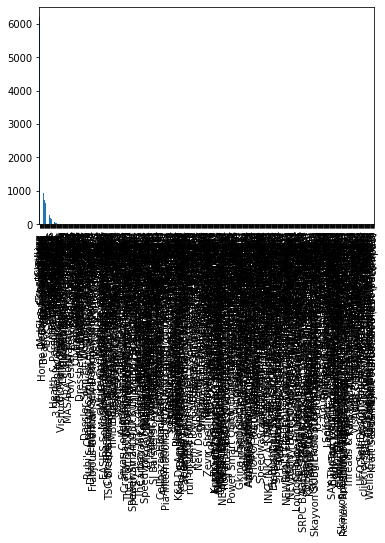

In [ ]:
flipkart_dataset_actual.primary_category.value_counts().plot(kind='bar')

The reason the above historgram isn't good is because there are too many categories which have too less products under them. This could either be because some of the values aren't categories(The regular expression that was used to split the inital product_category_tree column might have thrown some values which weren't actually categories) or even if they are categories they might have too few products under them. Instead a pie chart might be a better representation of how the products are distributed across categories

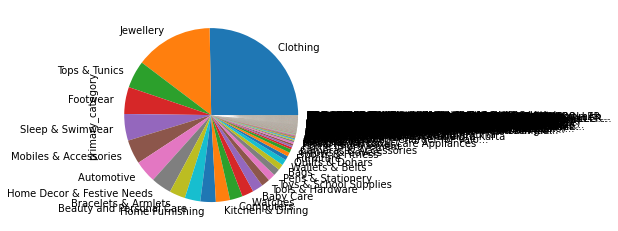

In [ ]:
flipkart_dataset_actual.primary_category.value_counts().plot(kind='pie')

Here as is clear above most of the products come under major categories like Clothing, Jewellery,etc. To further establish this we look at the number of products which fall under the top 40 categories ( the 40 categories with the most number of products in them). The selection of 40 as the number of categories is arbitrary

In [ ]:
# This command sums up the number of products in the 40 categories with the most number of products. The final sum is normalized, meaning it is a fraction of the total number
# of products present across all categories
flipkart_dataset_actual.primary_category.value_counts(normalize = True)[0:40].sum()

0.9648321161927298

The above result means that around 96.5% of all the products are in 40 categories. So it would be reasonable to omit most of the bottom categories, since we still have almost all the information in the original dataset retained

In [ ]:
# The command below filters those categories which have more than 20 products in them and filters them out
len(flipkart_dataset_actual.groupby("primary_category").filter(lambda x : len(x) > 20))/flipkart_dataset_actual.primary_category.value_counts().sum()

0.9623434376402431

This indicates that even if we emit all the categories which have less than 20 products in them, we retain 96.2% of the rows in the dataset. So it makes sense to apply this filter on the dataset because any category which has less than 20 products in a dataset with 20,000 products(roughly less than 0.1% of the products) is unlikely to give us any useful results 

In [ ]:
flipkart_dataset_actual = (flipkart_dataset_actual.groupby("primary_category").filter(lambda x : len(x) > 20))
flipkart_dataset_actual

,product_name,pid,description,brand,product_category_tree,primary_category
0,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing
1,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts,Sleep & Swimwear
2,FabHomeDecor Fabric Double Sofa Bed,SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor,Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...,Furniture
3,AW Bellies,SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW,Footwear >> Women's Footwear >> Ballerinas >> AW Bellies,Footwear
4,Alisha Solid Women's Cycling Shorts,SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing
...,...,...,...,...,...,...
24506,WallDesign Small Vinyl Sticker,STIE7KFJAKSTDY9G,Buy WallDesign Small Vinyl Sticker for Rs.730 online. WallDesign Small Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,WallDesign,Baby Care >> Baby & Kids Gifts >> Stickers >> WallDesign Stickers,Baby Care
24507,Wallmantra Large Vinyl Stickers Sticker,STIE9F5URNQGJCGH,Buy Wallmantra Large Vinyl Stickers Sticker for Rs.1143 online. Wallmantra Large Vinyl Stickers Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,Wallmantra,Baby Care >> Baby & Kids Gifts >> Stickers >> Wallmantra Stickers,Baby Care
24508,Elite Collection Medium Acrylic Sticker,STIE7VAYDKQZEBSD,Buy Elite Collection Medium Acrylic Sticker for Rs.999 online. Elite Collection Medium Acrylic Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,Elite Collection,Baby Care >> Baby & Kids Gifts >> Stickers >> Elite Collection Stickers,Baby Care
24509,Elite Collection Medium Acrylic Sticker,STIE8YSVEPPCZ42Y,Buy Elite Collection Medium Acrylic Sticker for Rs.1199 online. Elite Collection Medium Acrylic Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,Elite Collection,Baby Care >> Baby & Kids Gifts >> Stickers >> Elite Collection Stickers,Baby Care


As seen above the number of rows has reduced frm 24511 to 23588, with the missing rows indicative of the categories that we just removed. Now we reset the indices of the dataset, and also display the piechart with all the different categories 

In [ ]:
flipkart_dataset_actual.reset_index(inplace = True)
flipkart_dataset_actual

,index,product_name,pid,description,brand,product_category_tree,primary_category
0,0,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing
1,1,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts,Sleep & Swimwear
2,2,FabHomeDecor Fabric Double Sofa Bed,SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor,Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...,Furniture
3,3,AW Bellies,SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW,Footwear >> Women's Footwear >> Ballerinas >> AW Bellies,Footwear
4,4,Alisha Solid Women's Cycling Shorts,SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing
...,...,...,...,...,...,...,...
23583,24506,WallDesign Small Vinyl Sticker,STIE7KFJAKSTDY9G,Buy WallDesign Small Vinyl Sticker for Rs.730 online. WallDesign Small Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,WallDesign,Baby Care >> Baby & Kids Gifts >> Stickers >> WallDesign Stickers,Baby Care
23584,24507,Wallmantra Large Vinyl Stickers Sticker,STIE9F5URNQGJCGH,Buy Wallmantra Large Vinyl Stickers Sticker for Rs.1143 online. Wallmantra Large Vinyl Stickers Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,Wallmantra,Baby Care >> Baby & Kids Gifts >> Stickers >> Wallmantra Stickers,Baby Care
23585,24508,Elite Collection Medium Acrylic Sticker,STIE7VAYDKQZEBSD,Buy Elite Collection Medium Acrylic Sticker for Rs.999 online. Elite Collection Medium Acrylic Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,Elite Collection,Baby Care >> Baby & Kids Gifts >> Stickers >> Elite Collection Stickers,Baby Care
23586,24509,Elite Collection Medium Acrylic Sticker,STIE8YSVEPPCZ42Y,Buy Elite Collection Medium Acrylic Sticker for Rs.1199 online. Elite Collection Medium Acrylic Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,Elite Collection,Baby Care >> Baby & Kids Gifts >> Stickers >> Elite Collection Stickers,Baby Care


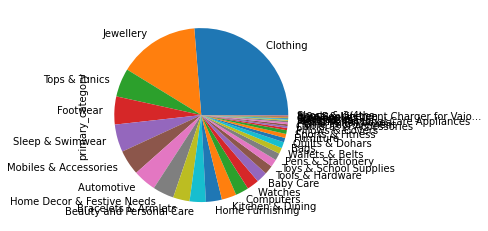

In [ ]:
flipkart_dataset_actual.primary_category.value_counts().plot(kind='pie')

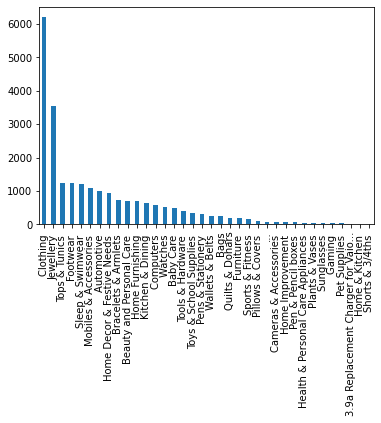

In [ ]:
flipkart_dataset_actual.primary_category.value_counts().plot(kind='bar')

In [ ]:
flipkart_dataset_actual.primary_category.value_counts()

Clothing                                6198
Jewellery                               3531
Tops & Tunics                           1251
Footwear                                1227
Sleep & Swimwear                        1212
Mobiles & Accessories                   1099
Automotive                              1012
Home Decor & Festive Needs               929
Bracelets & Armlets                      724
Beauty and Personal Care                 710
Home Furnishing                          700
Kitchen & Dining                         647
Computers                                578
Watches                                  530
Baby Care                                483
Tools & Hardware                         391
Toys & School Supplies                   330
Pens & Stationery                        313
Wallets & Belts                          265
Bags                                     265
Quilts & Dohars                          190
Furniture                                180
Sports & F

There are two categories above which we look at -<br/>
* The first is the category *'...'* which has 82 products in it. This isn't actually a category name and needs to be droppped.
* The second is the category *'3.9a Replacement Charger for Vaio...'* -  This again isn't actually a product category, but rather reads like a subcategory (Replacament chargers should probably come under Mobiles & Accesories). So we need to drop this category as well 

In [ ]:
flipkart_dataset_actual = flipkart_dataset_actual[(flipkart_dataset_actual.primary_category != '...') & (flipkart_dataset_actual.primary_category != '3.9a Replacement Charger for Vaio...')]

In [ ]:
flipkart_dataset_actual.primary_category.value_counts()

Clothing                              6198
Jewellery                             3531
Tops & Tunics                         1251
Footwear                              1227
Sleep & Swimwear                      1212
Mobiles & Accessories                 1099
Automotive                            1012
Home Decor & Festive Needs             929
Bracelets & Armlets                    724
Beauty and Personal Care               710
Home Furnishing                        700
Kitchen & Dining                       647
Computers                              578
Watches                                530
Baby Care                              483
Tools & Hardware                       391
Toys & School Supplies                 330
Pens & Stationery                      313
Bags                                   265
Wallets & Belts                        265
Quilts & Dohars                        190
Furniture                              180
Sports & Fitness                       166
Pillows & C

We have now have a total of 34 primary categories that all the products belong to. Since we have extracted the primary category for all products, the next task is to *pre-process the text description in a manner that will be suitable for us to feed into the model*

### **Preprocessing the product descriptions**


The first thing to do is to *create a new dataset* which initally only *contains the product descriptions* . These transformations are first done in a separate dataset instead of in the original dataset itself to ensure that some operation performed by mistake doesn't change the original dataset

In [ ]:
flipkart_dataset_actual["description_converted"] = flipkart_dataset_actual["description"].astype(str)
flipkart_dataset_actual.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,product_name,pid,description,brand,product_category_tree,primary_category,description_converted
0,0,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ..."
1,1,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts,Sleep & Swimwear,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ..."
2,2,FabHomeDecor Fabric Double Sofa Bed,SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor,Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...,Furniture,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame..."
3,3,AW Bellies,SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW,Footwear >> Women's Footwear >> Ballerinas >> AW Bellies,Footwear,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular..."
4,4,Alisha Solid Women's Cycling Shorts,SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl..."


**We convert all the *descriptions to lower case* using the desc_lowercase**

In [ ]:
flipkart_dataset_actual["description_converted"] = flipkart_dataset_actual["description_converted"].str.lower()
flipkart_dataset_actual.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,product_name,pid,description,brand,product_category_tree,primary_category,description_converted
0,0,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing,"key features of alisha solid women's cycling shorts cotton lycra navy, red, navy,specifications of alisha solid women's cycling shorts shorts details number of contents in sales package pack of 3 fabric cotton lycra type cycling shorts general details pattern solid ideal for women's fabric care ..."
1,1,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts,Sleep & Swimwear,"key features of alisha solid women's cycling shorts cotton lycra navy, red, navy,specifications of alisha solid women's cycling shorts shorts details number of contents in sales package pack of 3 fabric cotton lycra type cycling shorts general details pattern solid ideal for women's fabric care ..."
2,2,FabHomeDecor Fabric Double Sofa Bed,SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor,Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...,Furniture,"fabhomedecor fabric double sofa bed (finish color - leatherette black mechanism type - pull out) price: rs. 22,646 • fine deep seating experience • save space with the all new click clack sofa bed • easy to fold and vice versa with simple click clack mechanism • chrome legs with mango wood frame..."
3,3,AW Bellies,SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW,Footwear >> Women's Footwear >> Ballerinas >> AW Bellies,Footwear,"key features of aw bellies sandals wedges heel casuals,aw bellies price: rs. 499 material: synthetic lifestyle: casual heel type: wedge warranty type: manufacturer product warranty against manufacturing defects: 30 days care instructions: allow your pair of shoes to air and de-odorize at regular..."
4,4,Alisha Solid Women's Cycling Shorts,SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing,"key features of alisha solid women's cycling shorts cotton lycra black, red,specifications of alisha solid women's cycling shorts shorts details number of contents in sales package pack of 2 fabric cotton lycra type cycling shorts general details pattern solid ideal for women's fabric care gentl..."


**Removing the puncuations from the *desc_lowercase column* and adding that to a new column called desc_lower_wopunc.**
In this we replace all the punctuations with spaces. This is because in a lot of places the commas are not followed by spaces, so removing the punctuations would lead to certain words being joined together instead of being separated by spaces.
We can then process this text by removing multiple spaces

In [ ]:
def remove_punctuation(text) :
 return text.translate(str.maketrans(string.punctuation,' '*len(string.punctuation)))

flipkart_dataset_actual["description_converted"] = flipkart_dataset_actual["description_converted"].apply(lambda text : remove_punctuation(text))

In [ ]:
flipkart_dataset_actual["description_converted"][0]

'key features of alisha solid women s cycling shorts cotton lycra navy  red  navy specifications of alisha solid women s cycling shorts shorts details number of contents in sales package pack of 3 fabric cotton lycra type cycling shorts general details pattern solid ideal for women s fabric care gentle machine wash in lukewarm water  do not bleach additional details style code altht 3p 21 in the box 3 shorts'

As seen above there are two spaces in some of the descriptions (for example it says '*navy  red*' instead of '*navy red*'). We remove all the multiple spaces in the string using a regex command. 

In [ ]:
flipkart_dataset_actual["description_converted"] = flipkart_dataset_actual["description_converted"].apply(lambda text : re.sub(' +', ' ', text))
flipkart_dataset_actual["description_converted"][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


'key features of alisha solid women s cycling shorts cotton lycra navy red navy specifications of alisha solid women s cycling shorts shorts details number of contents in sales package pack of 3 fabric cotton lycra type cycling shorts general details pattern solid ideal for women s fabric care gentle machine wash in lukewarm water do not bleach additional details style code altht 3p 21 in the box 3 shorts'

In the above text data all the 

**Removing the stopwords**<br/>
Stop words are words if,and,an,...,etc. which don't contribute towards the final meaning of a sentence. While they are important synctactically in most situations they aren't necessary to find the meaning of the word. Hence, removing them won't affect our final prediction 

In [ ]:
#First we look at all the stopwords defined in nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

The words above can be removed from our product descriptions 

In [ ]:
STOPWORDS = stopwords.words('english')

def remove_stopwords(text) :
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])

flipkart_dataset_actual["description_converted"] = flipkart_dataset_actual["description_converted"].apply(lambda text : remove_stopwords(text))
flipkart_dataset_actual["description_converted"].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    key features alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack 3 fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewar...
1    key features alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack 3 fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewar...
2    fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull price rs 22 646 • fine deep seating experience • save space new click clack sofa bed • easy fold vice versa simple click clack mechanism • chrome legs mango wood frame long term durability • double cushioned s...
3    key features aw bellies sandals wedges heel casuals aw bellies price rs 499 mate

**Remove all digits**<br/>

There are a lot of numbers in our product descriptions ( the product price, quantity, etc.). These numbers can be removed because they don't tell us much about the final product category 

In [ ]:
def remove_digits(text) :
  return text.translate(str.maketrans(string.digits,' '*len(string.digits)))

flipkart_dataset_actual["description_converted"] = flipkart_dataset_actual["description_converted"].apply(lambda x : remove_digits(x))
flipkart_dataset_actual["description_converted"].head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0    key features alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack   fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewar...
1    key features alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack   fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewar...
2    fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull price rs        • fine deep seating experience • save space new click clack sofa bed • easy fold vice versa simple click clack mechanism • chrome legs mango wood frame long term durability • double cushioned s...
3    key features aw bellies sandals wedges heel casuals aw bellies price rs     mate

As before we realise that there are multiple spaces in our product descriptions because some digits have been replaced by whitespaces. We remove multiple spaces from our product descriptions

In [ ]:
flipkart_dataset_actual["description_converted"] = flipkart_dataset_actual["description_converted"].apply(lambda text : re.sub(' +', ' ', text))
flipkart_dataset_actual["description_converted"].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    key features alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewarm ...
1    key features alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewarm ...
2    fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull price rs • fine deep seating experience • save space new click clack sofa bed • easy fold vice versa simple click clack mechanism • chrome legs mango wood frame long term durability • double cushioned sofa bed...
3    key features aw bellies sandals wedges heel casuals aw bellies price rs material

**Removing common words**<br/>
Some words will appear regularly in descriptions across all categories. For instance since this dataset is from Flipkart it is likely that the word 'flipkart' will appear regularly. Since these words don't add anything meaningful to our final answer it makes sense to remove them. However it is also possible that some words appear commonly in a certain product category. There might be words like fabric which are very common in the Clothing Category. We should be careful not to remove these words

In [ ]:
from collections import Counter
cnt = Counter()
for text in flipkart_dataset_actual["description_converted"].values:
    for word in text.split():
        cnt[word] += 1
        
(cnt.most_common(20))

[('rs', 21171),
 ('women', 15329),
 ('buy', 13685),
 ('online', 12980),
 ('com', 12841),
 ('flipkart', 12670),
 ('free', 9532),
 ('products', 9485),
 ('day', 9010),
 ('genuine', 8800),
 ('delivery', 8682),
 ('cash', 8642),
 ('shipping', 8616),
 ('replacement', 8445),
 ('guarantee', 7981),
 ('price', 7808),
 ('features', 7807),
 ('shirt', 7690),
 ('casual', 7127),
 ('collection', 6501)]

In the above 20 words, there are 4 words which we should be careful not to remove 

1. *women* - It is possible that certain product categories cater more to female buyers than others. So removing the word women may make us lose some important information about the product category 
2. *shirt* - If a product description has the word shirt in it, it almost certainly belongs to the Clothing category, so we should not remove it 
3. *casual* - Words like casual are more likely to appear in Clothing products ( Casual T-shirt for example). So we should not remove this word
4. *collection* - The word collection too is likely to appear in Clothing products so we shouldn't remove it either(Collection of 4 shirts, etc.) 

The rest of the words ( 16 of them) can be stored in a list and removed 

In [ ]:
common_words = [word[0] for word in cnt.most_common(20)]
keep_words = ["women","shirt","casual","collection"]

remove_words = [word for word in common_words if word not in keep_words]


def remove_common(text) :
  return " ".join([word for word in str(text).split() if word not in remove_words])

flipkart_dataset_actual["description_converted"] = flipkart_dataset_actual["description_converted"].apply(lambda x : remove_common(x))
flipkart_dataset_actual["description_converted"].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


0    key alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewarm water ble...
1    key alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewarm water ble...
2    fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull • fine deep seating experience • save space new click clack sofa bed • easy fold vice versa simple click clack mechanism • chrome legs mango wood frame long term durability • double cushioned sofa bed provide ...
3    key aw bellies sandals wedges heel casuals aw bellies material synthetic lifesty

In [ ]:
flipkart_dataset_actual.head()

,index,product_name,pid,description,brand,product_category_tree,primary_category,description_converted
0,0,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing,key alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewarm water ble...
1,1,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care ...",Alisha,Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts,Sleep & Swimwear,key alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewarm water ble...
2,2,FabHomeDecor Fabric Double Sofa Bed,SBEEH3QGU7MFYJFY,"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame...",FabHomeDecor,Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo...,Furniture,fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull • fine deep seating experience • save space new click clack sofa bed • easy fold vice versa simple click clack mechanism • chrome legs mango wood frame long term durability • double cushioned sofa bed provide ...
3,3,AW Bellies,SHOEH4GRSUBJGZXE,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synthetic Lifestyle: Casual Heel Type: Wedge Warranty Type: Manufacturer Product Warranty against manufacturing defects: 30 days Care instructions: Allow your pair of shoes to air and de-odorize at regular...",AW,Footwear >> Women's Footwear >> Ballerinas >> AW Bellies,Footwear,key aw bellies sandals wedges heel casuals aw bellies material synthetic lifestyle casual heel type wedge warranty type manufacturer product warranty manufacturing defects days care instructions allow pair shoes air de odorize regular basis use shoe bags prevent stains mildew dust dry dirt surfa...
4,4,Alisha Solid Women's Cycling Shorts,SRTEH2F6HUZMQ6SJ,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 2 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentl...",Alisha,Clothing >> Women's Clothing >> Lingerie,Clothing,key alisha solid women cycling shorts cotton lycra black red specifications alisha solid women cycling shorts shorts details number contents sales package pack fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewarm water bleach ...


There are 4 columns in 'flipkart_dataset_actual' that we can drop now without any issues 
1. *index* - This column is unnecessary since we already have a separate column maintaining the indices of the rows
2. *description* - Since we already have our processed description in description_converted we can drop the description column
3. *product_category_tree* - We already have the primary categories for all the products so it makes sense to drop the trees 
4. *pid* - it doesn't exactly help us predict the product category ( **Note** : It's possible that all products in a certain category have a particular type of product ID, however we will not use this information in this task since the category needs to be predicted using the description) 

In [ ]:
flipkart_dataset_actual.drop(columns = ["index","pid","description","product_category_tree"],inplace= True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
flipkart_dataset_actual.head()

**Saving dataframe in a CSV file** 

In [ ]:
flipkart_dataset_actual.to_csv(r'/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/flipkart_dataset.csv',index=False)

In [ ]:
#Checking to see whether the dataframe has been stored as we want it to be 
pd.options.display.max_colwidth = 300

my_dataset = pd.read_csv('/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/flipkart_dataset.csv')
my_dataset.head()

**Splitting the dataset into train, validation and test sets, which can then be saved as separate CSV files** 

The training sets are used for training the model, while the validation set is used for evaluating the model and fine-tuning the hyperparameters. Once all the fine-tuning is completed the model is tested on the test set, to check the final accuracy  

In [ ]:
# We set a constant seed to be able to reproduce the result 
SEED = 11
train_data,test_data = train_test_split(my_dataset,test_size = 0.25,random_state = SEED)

In [ ]:
# To get the validation set, we split the training set attained in the previous set, with 80% of the entries being in the training set
train_data,valid_data = train_test_split(train_data,test_size = 0.2, random_state = SEED)

We look at the **distribution of the train,test and validation datasets** to make sure that the products are distributed uniformly enough to be able to make a reasonable estimate of the final accuracy 

In [ ]:
train_data["primary_category"].value_counts(),valid_data["primary_category"].value_counts(),test_data["primary_category"].value_counts()

In [ ]:
train_data.head()

,product_name,brand,primary_category,description_converted
10441,Sonata 8925YM06J Analog Watch - For Women,NaN,Watches,sonata ym j analog watch women sonata ym j analog watch women ym j india round dial golden strap water resistant great discounts
3666,Urbaano Women's Full Coverage Bra,Pink,Clothing,urbaano women full coverage bra urbaano catering needs customers innovative premium quality innerwear keeping mind changing needs today active woman lovely lace bra ladies always remain bride heart lace pattern give delicate look come vibrant colours enlighten lives intricate silver trim neck li...
5746,Lal Haveli Traditional Hand Crafted Beautiful Iron Musician 5 Pcs Set Showpiece - 33 cm,Lal Haveli,Home Decor & Festive Needs,lal haveli traditional hand crafted beautiful iron musician pcs set showpiece cm lal haveli traditional hand crafted beautiful iron musician pcs set showpiece cm best prices
6072,Allure Auto CM 1770 Car Mat Mahindra Xylo,Allure Auto,Automotive,allure auto cm car mat mahindra xylo allure auto cm car mat mahindra xylo best prices
21232,Leebo L86 Projector Lens,Leebo,Automotive,specifications leebo l projector lens general brand leebo lens diameter cm vehicle model name ninja model number l power consumption w light color white red blue vehicle brand kawasaki color temperature voltage v vehicle model year lifespan vehicle type motorbike box projector lens


In [ ]:
train_data.to_csv(r'/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/flipkart_dataset_train.csv')
valid_data.to_csv(r'/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/flipkart_dataset_valid.csv')
test_data.to_csv(r'/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/flipkart_dataset_test.csv')

### **Creating PyTorch dataset and iterators from the saved dataframes**

* We use the standard str.split() as tokenizer which takes a sentence/paragraphs tokenizes it using white spaces as a separator. So you get a list of words as output, and since we don't have any punctuations in our dataframe this is sufficient 
* data.Field() defines how to process a given input text data and convert it into a tensor. 
* The DESCRIPTION data.Field() says that the input being passed to it will be sequntial(*sequential = True*), that a vocabulary object should be used on the input(*use_vocab = True*, this is used on text data which converts the individual words into numbers by building a vocabulary on the input data) 
* The CATEGORY data.Field() says that that the input being to it will not be sequential ( as is the case with our category labels), and that *use_vocab = True* which means that the data being inputted will be text data

In [13]:
tokenize = lambda x : x.split()
DESCRIPTION = data.Field(sequential = True, use_vocab = True,tokenize= tokenize, lower = True)
CATEGORY = data.Field(sequential = False, use_vocab= True)

fields = {'description_converted' : ('d',DESCRIPTION), 'primary_category' : ('c',CATEGORY)}


In [14]:
train_flipkart_data,valid_flipkart_data, test_flipkart_data = data.TabularDataset.splits(
                                                                path = '/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce',
                                                                train = 'flipkart_dataset_train.csv',
                                                                validation = 'flipkart_dataset_valid.csv',
                                                                test = 'flipkart_dataset_test.csv',
                                                                format = 'csv',
                                                                fields = fields
                                                              )

In the first three lines we set a SEED to ensure that the results are reproducible. 

We also define the BATCH SIZE and device to train our models

In [15]:
# To ensure reproducibility of results
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Defining the batch size, and device ( if a GPU is available it is used otherwise we use a CPU) 
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [16]:
device

device(type='cpu')

We use the data.BucketIterator module to be able to divide the training, validation, and test data into batches 

In [17]:
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_flipkart_data, valid_flipkart_data, test_flipkart_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort = False)


data.Field.build_vocab() module is used to build a vocabulary of words from the given corpus of data. The arguments to the method are explained below  :
* max_size defines what the maximum size of the vocabulary should be. In this case we set it to be 25000 words
* The vectors argument determines what vector representation we should use for each of the words in the vocabulary. In this case we use the glove 100 dimensional word embedding representation. 
* unk_init - this decides what to do with words that aren't in the vocabulary. 
* min_freq - this argument determines what the minimum frequency of a word needs to be in the corpus for it to be a part of the vocabulary. In this case, we set min_freq = 2 which means that words which appear only once in the corpus don't feature in the vocabulary

In [18]:
MAX_VOCAB_SIZE = 25_000

DESCRIPTION.build_vocab(train_flipkart_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_,
                 min_freq = 2)

CATEGORY.build_vocab(train_flipkart_data)


.vector_cache/glove.6B.zip: 862MB [02:43, 5.29MB/s]                           
100%|█████████▉| 399811/400000 [00:20<00:00, 18590.05it/s]

We look at the mapping from the Category Name to the number each of these categories is assigned to. So every category in the dataset is mapped to some number as can be seen below. The vocabulary of Category name basically has 35 words ( there's one extra to account for unknown categories)<br/>
Similarly there is a vocabulary for the description column as well which consists of all the words which appear in the descriptions of all products ( Since our minimum frequency is 2, only those words which appear in the descriptions more than once form a part of the vocabulary

In [19]:
DESCRIPTION.vocab.vectors.shape

torch.Size([13066, 100])

### **Defining the train, evaluation, and accuracies for models**

One thing to realise here is that overall batch accuracy might not be the most 
accurate metric for evaluating the performance of our model. This is because our classes are imbalanced ( certain classes have more products than others do ) . <br/>
So a better evaluation metric would be to look at the predictions that the model gives for each of the classes through True Positives, False Negatives, and False Positives and evaluate the precision and recall for all the classes 
We could use the F1 score which combines the precision and recall to give a single score to evaluate how well the model does on each class

Precision of Class = (True Positives/(True Positives + False Positives))<br/>
Recall of Class = (True Positives/ (True Positives + False Negatives ) ) <br/>
F1 score = 2 \* ( Precision \* Recall ) /(Precision + Recall)<br/>

We also add 'torch.nan_to_num(tensor)' lines to ensure that the tensors that any nan values that are formed ( due to dividing by zero) are converted to zeros

The method to build these matrices for a given batch is as follows : 
* Given a prediction tensor of dimensions (batch size, num_categ), we get the maximum maximum value for each batch size, to get the top_predic tensor of dimensions (batch size), where each element contains the predicted category number 
* We iterate through every element the top_predic tensor. For a given i if top_predic[i] = y[i], that would be a true positive for the predicted category so we update that 
* If for a given i the top_predic[i] != y[i], then it is a false positive for the predicted category, and a false negative for the category 'y[i]' so we make the updates accordingly 
* We then calculate the batch precision, recall, and F1 scores using the formulae listed above 


In [20]:
num_categ = len(CATEGORY.vocab)
num_categ

35

In [21]:
# Here TruePositives[i] gives the number of TruePositive predictions for 

def batch_F1Scores(preds,y) :
  num_categ = len(CATEGORY.vocab.stoi)
  TruePositives = torch.zeros(num_categ)
  FalseNegatives = torch.zeros(num_categ)
  FalsePositives = torch.zeros(num_categ)
  
  with torch.no_grad():
    top_predic = preds.argmax(1, keepdim = False)
    #print(f"Shape of top predictions : {top_predic.shape}")
    #print(f"Shape of batch.c : {batch.c.shape}")
    for i in range(top_predic.shape[0]) :
        if ((top_predic[i]) == (y[i])) :
          TruePositives[top_predic[i]] = TruePositives[top_predic[i]] + 1
        else :
          FalseNegatives[y[i]] = FalseNegatives[y[i]] + 1
          FalsePositives[top_predic[i]] = FalsePositives[top_predic[i]] + 1 
    
  Precision = (TruePositives)/(TruePositives + FalsePositives)
  Recall = (TruePositives)/(TruePositives + FalseNegatives)
  Precision =  torch.nan_to_num(Precision)
  Recall = torch.nan_to_num(Recall)
  F1Scores = 2 * Precision * Recall/(Precision + Recall)
  F1Scores = torch.nan_to_num(F1Scores)
  return F1Scores

**Training loop**

*   we set both the epoch loss and the F1 score of that epoch(shape - (batch size ,1) 
* model.train() is initiated to indicate to the model that it is being trained 
* We iterate through every batch and calculate the loss and F1 score at every batch.
* loss.backward() completes the backpropagation and calculates the gradients. optimizer.step() updates the parameters of the model 
* optimizer.zero_grad() at the beginning of each loop initiates the gradients to be zero 

In [22]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_F1 = torch.zeros(num_categ)
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.d)
        
        loss = criterion(predictions, batch.c)
        
        F1 = batch_F1Scores(predictions, batch.c)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_F1 += F1
        
    return epoch_loss / len(iterator), epoch_F1 / len(iterator)


The evaluate() function is similar except for 2 differences
* model.eval() is used to tell the model that the model is going to be evaluated 
* with torch.no_grad() implies that the gradients are not calculated since we are only evaluating the model

In [23]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_F1 = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.d)
            
            loss = criterion(predictions, batch.c)
            
            F1 = batch_F1Scores(predictions, batch.c)

            epoch_loss += loss.item()
            epoch_F1 += F1
        
    return epoch_loss / len(iterator), epoch_F1 / len(iterator)


### **CNN for text classification**

**Explaining the CNN Architecture**

* Embedding layer 
    - Takes in a *input tensor of shape (batch_size, len_of_sentence)*, and converts the sentences to their GloVe vector represenations to give *output tensor of shape (batch_size,len_of_sentence, embedding_dimensions)* - in this case embedding_dimensions = 50
    
* Convolutional Layer (convLayers) 
    - It takes an *input tensor of shape (batch_size,len_of_sentence, embedding_dimensions)* and performs convolutional operations on it 

    - This layer is a *list of nn.conv2D* operations which has the same length as the number of filter sizes. So if the filter sizes are 2,3, and 4 it will *return a list of 3 tensors each of dimensions (batch_size, n_filters, len_of_sentence - filter_size[i] ) *, where i is the index of the tensor in the list
    - Let's consider a filter size of 2 - the filter has dimensions (2, embedding_dim). This filter performs a convolution operatoion on each member of a batch ( dimensions - (batch_size, 1, len_of_sentence,embedding_dim) ). So essentially if we consider a particular description as a matrix of dimensions (len_of_sentence,embedding_dim), the filter moves vertically downwards on this matrix, performing a convolution operation to give a final vector of dimensions (len_of_sentence - embedding_dim). Since there are n_filters of each filter size, the final dimensions per description becomes (n_filters, len_of_sentence - embedding_dim). Since this operation in term is performed batchwise we have a final output tensor of dimensions (batch_size,n_filters,len_of_sentence-embedding_dim, 1)

    - For more reference,  [nn.Conv2d()](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

* Relu layer 
    - Here essentially we *return a list of tensors each of dimensions (batch_size,n_filters,len_of_sentence-embedding_dim* . This corresponds to performing the [F.relu()](https://pytorch.org/docs/stable/nn.functional.html#relu) operation on each of the elements of the tensor obtained from convolved layer ( with the last dimension squeezed) 

* Pooling layer 
     - In this, we *return a list of tensors, each of whose elements has dimensions batch_size, n_filters* 
     - This essentially applies a max pooling layer over the last dimension of the output from the Relu layer ( extracts the maximum element ) , to get a list of tensors
     - The intuition behind this is that we manage to extract the most important ( most active) from each of the filters that we use, and this can help us get a classification 

* Dropout layer followed by Concatenation
    - We add a dropout layer to help with regularization ( preventing overfitting ) on the output from the Pooling layer
    - Once we have applied dropout, we concatenate the individual tensors in the list to get a single tensor of dimensions ( batch_size, n_filters * len(filter_size) ) 
  
* Fully connected layer 
    - This takes the tensor from the previous step, and feeds it to a fully connected layer to give an output tensor of dimensions (batch_size,output_dim). The output dimensions in this case is the number of categories.
    - The category which has the highest activation is our final prediction 

**Why does using this architecture make sense?**



In [12]:
class CNNClassify(nn.Module) :
  def __init__(self, vocab_size, embedding_dim, n_filters,filter_sizes,output_dim,dropout_rate,pad_idx) :
    super().__init__()
    # The first layer is an Embedding layer used to convert the words to their corresponding GloVe vector representation 
    self.embedding = nn.Embedding(vocab_size,embedding_dim)
    
    # We have a convLayers, which is a ModuleList(a list of ) 
    self.convLayers = nn.ModuleList([nn.Conv2d(in_channels = 1,out_channels = n_filters,kernel_size = (fs,embedding_dim)) for fs in filter_sizes ])

    # A fully connected layer which takes in 
    self.fullyConnect = nn.Linear(len(filter_sizes) * n_filters, output_dim) 
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self,text) :
    # Since the text we receive is of dimensions (len_of_sentence,batch_size) we switch the dimensions. This is similar to the transpose operation
    text = text.permute(1,0)

    # Converting the sentence into its GloVe Vector representation
    embedded_sentence = self.embedding(text)

    # The dimensions of embedded_sentence are (batch_size, len_of_sentence, embedding_dim) - we change dimensions to (batch_size, 1,len_of_sentence, embedding_dim) using unsqueeze
    # function in order to perform the convolution operation 
    embedded_sentence = embedded_sentence.unsqueeze(1)

    # Performing the convolution operations on the embedded_sentece
    convolved =  [F.relu(conv(embedded_sentence)).squeeze(3) for conv in self.convLayers]

    # Dimensions of convolved[i] = (batch_size, n_filters, len_of_sentence - filter_sizes[i])and i ranges from 0 to len(filter_size) - 1

    pooled_layer = [F.max_pool1d(conv,conv.shape[2]).squeeze(2) for conv in convolved]


    # Dimensions of pooled_layer[i] = (batch_size, n_filters)

    cat_layer = self.dropout(torch.cat(pooled_layer,dim = 1))

    # Dimensions of cat_layer = (batch_size, n_filters * len(filter_size) )
    return self.fullyConnect(cat_layer)


In [24]:
VOCAB_SIZE = len(DESCRIPTION.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4,5,6]
OUTPUT_DIM = len(CATEGORY.vocab)
DROPOUT = 0.5
PAD_IDX = DESCRIPTION.vocab.stoi[DESCRIPTION.pad_token]

CNNmodel = CNNClassify(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)


In [ ]:
CNNmodel

CNNClassify(
  (embedding): Embedding(13066, 100)
  (convLayers): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (3): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
    (4): Conv2d(1, 100, kernel_size=(6, 100), stride=(1, 1))
  )
  (fullyConnect): Linear(in_features=500, out_features=35, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

We copy our GloVe 100 dimensional word embeddings to the embedding layer of the Model 

In [ ]:
CNNmodel.embedding.weight.data.copy_(DESCRIPTION.vocab.vectors)
CNNmodel.embedding.weight.data

tensor([[ 0.3374, -0.1778, -0.3035,  ...,  0.2770,  0.6455, -0.8957],
        [ 0.4928, -0.0141, -0.2747,  ...,  0.0493,  0.8484,  0.4671],
        [ 0.8338,  0.9443, -0.0114,  ..., -0.1500,  0.8400,  0.4852],
        ...,
        [-0.1623, -0.0926, -1.1067,  ...,  0.0262, -0.0052, -2.3561],
        [-0.1873,  0.2027,  1.1976,  ...,  0.3397, -0.1919,  1.0648],
        [-1.1966,  0.0796, -1.1000,  ..., -0.8675,  0.4538, -0.4539]])

We also set the embeddings of the unknown word and padding words to be equal to 0 ( So in our case the unknown words and pad words will have 50 dimensional vectors with all zeroes)

In [ ]:
UNK_IDX = DESCRIPTION.vocab.stoi[DESCRIPTION.unk_token]

CNNmodel.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
CNNmodel.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
CNNmodel.embedding.weight.data


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.8338,  0.9443, -0.0114,  ..., -0.1500,  0.8400,  0.4852],
        ...,
        [-0.1623, -0.0926, -1.1067,  ...,  0.0262, -0.0052, -2.3561],
        [-0.1873,  0.2027,  1.1976,  ...,  0.3397, -0.1919,  1.0648],
        [-1.1966,  0.0796, -1.1000,  ..., -0.8675,  0.4538, -0.4539]])

We now define our optimizer which is used to update the parameters and our loss function. 
* For optimization we use the Adam optimizer 
* The loss function is defined to be the Cross Entropy loss 

We also move our model, and criterion ( loss function) to the GPU to be able to train the model

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(CNNmodel.parameters(),lr = 0.01)
criterion = nn.CrossEntropyLoss()

CNNmodel = CNNmodel.to(device)
criterion = criterion.to(device)


We train the model for 5 epochs,

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    train_loss, train_F1 = train(CNNmodel, train_iterator, optimizer, criterion)
    valid_loss, valid_F1 = evaluate(CNNmodel, valid_iterator, criterion)
        
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print("Training F1 Scores")
    for i in range(train_F1.shape[0]) :
      categ_name = CATEGORY.vocab.itos[i] 
      print(f"Category - {categ_name} , Frequency :{CATEGORY.vocab.freqs[categ_name]}, F1 Score : {train_F1[i]}")
    print(" ")

    print(f'\t Val. Loss: {valid_loss:.3f}')
    for i in range(valid_F1.shape[0]) :
      categ_name = CATEGORY.vocab.itos[i] 
      print(f"Category - {categ_name} , Frequency :{CATEGORY.vocab.freqs[categ_name]}, F1 Score : {valid_F1[i]}")
    
    print("--------------------")


Epoch: 01
	Train Loss: 1.138
Training F1 Scores
Category - <unk> , Frequency :0, F1 Score : 0.0
Category - Clothing  , Frequency :3740, F1 Score : 0.7350893616676331
Category - Jewellery  , Frequency :2122, F1 Score : 0.8458963632583618
Category - Tops & Tunics  , Frequency :757, F1 Score : 0.29800519347190857
Category - Footwear  , Frequency :730, F1 Score : 0.8085187673568726
Category - Sleep & Swimwear  , Frequency :728, F1 Score : 0.3048875629901886
Category - Mobiles & Accessories  , Frequency :653, F1 Score : 0.7855855226516724
Category - Automotive  , Frequency :600, F1 Score : 0.8157932758331299
Category - Home Decor & Festive Needs  , Frequency :558, F1 Score : 0.6786298751831055
Category - Beauty and Personal Care  , Frequency :462, F1 Score : 0.5928982496261597
Category - Bracelets & Armlets  , Frequency :433, F1 Score : 0.2614552080631256
Category - Home Furnishing  , Frequency :423, F1 Score : 0.48012712597846985
Category - Kitchen & Dining  , Frequency :396, F1 Score : 0.

Before we think about looking at the test set perhaps one thing that would be useful is to look at for which categories the F1 scores are really poor ( especially the ones which have a high frequency - because this gives us an indication of perhaps why the model is failing ) 

One trend that we see is that Categories which have very less products ( such as Gaming, Shorts & 3/4ths, Sunglasses, etc.) seem to give incorrect predictions. This is understandable because there are very few examples for the model to even learn from.

However, the model also does surprisingly poorly on certain categories with plenty of products such as Tops & Tunics, Sleep & Swimwear which have F1 scores of 0.03 and 0.02 respectively. One reason that strikes intuitively is that the model predicts these to be Clothing products ( most Swimwear products are also Clothing products ) . To gauge whether this hypothesis is true we look at the predictions that the model makes for these categories and analyse the results

We look at the first 20 predictions for the Sleep & Swimwear, Tops & Tunics category 

#### **Deciding what other categories to remove**

In [75]:
# Saving the previous model in drive
torch.save(CNNmodel.state_dict(), '/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/CNNmodel1.pt')


In [32]:
myModel_para = torch.load('/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/CNNmodel1.pt',map_location=torch.device('cpu'))

In [33]:
myModel = CNNClassify(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
myModel.load_state_dict(myModel_para)


<All keys matched successfully>

In [34]:
myModel

CNNClassify(
  (embedding): Embedding(13066, 100)
  (convLayers): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (3): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
    (4): Conv2d(1, 100, kernel_size=(6, 100), stride=(1, 1))
  )
  (fullyConnect): Linear(in_features=500, out_features=35, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [35]:
def get_description(desc_tensor) : 
  return " ".join(DESCRIPTION.vocab.itos[word_num] for word_num in desc_tensor)

In [36]:
def get_wrong_predictions( categ_name, iterator, model) :
  count = 0
  categ_num = CATEGORY.vocab.stoi[categ_name]
  print(f"20 Wrong predictions of Category : {categ_name}, number : {categ_num}")
  
  
  for batch in iterator : 
    target = batch.c
    predics = model(batch.d)
    top_predics = predics.argmax(1,keepdim = False)
    for i in range(len(target)) :
      if(target[i] == categ_num  and top_predics[i] != categ_num) :
        count = count + 1
        print(f"Description : {get_description(batch.d[i])}")
        print(f"Actual Category : {CATEGORY.vocab.itos[target[i]]}")
        print(f"Predicted Category : {CATEGORY.vocab.itos[top_predics[i]]}")
      if ( count > 20) :
        break

In [ ]:
get_wrong_predictions('Tops & Tunics ',valid_iterator,myModel)

In [ ]:
get_wrong_predictions('Sleep & Swimwear ',valid_iterator,myModel)

There are two observations to be made here -  the first is that in both the case of 'Sleep & Swimwear' and in the case of 'Tops & Tunics ' most of the wrong predictions come because they are predicted as clothes. 
It's important to note that these predictions aren't wrong per say - the descriptions of these products clearly suggest that almost all of them are indeed Clothing products. <br/>

Given that this is the case, and that we barely achiev any accuracy for either of these categories due to most products being predicted as belonging to the Clothing Category it would be appropriate to remove these 2 categories from the dataset and then train the model(s). The other thing to point out is that a lot of the categories with less number of products which are giving poor results also need to be dropped simply because no model will be able to produce better results for these categories given how few products exist in the first place. 
A good threshold would be to look at the F1 scores, and expect that if there are less than 200 products of a certain category (the choice of 200 is arbitrary but out of 14000 products in the training set, these categories appear less than 200 times - that is around 1.5% of the total size of the dataset, which simply does not give us information to make a reasonable prediction), they are likely to produce poor results. And clearly, as we see above all categories which have less than 50 products in the training set do not produce an F1 score that is more than 0.4<br/>
The categories that we then drop are as follows 

* Sleep & Swimwear
* Tops & Tunics
* Pillows & Covers 
* Cameras & Accessories
* Pen & Pencil boxes
* Home Improvement  
* Health & Personal Care Appliances
* Plants & Vases  
* Pet Supplies  
* Home & Kitchen
* Sunglasses 
* Gaming 
* Shorts & 3/4ths

It would also be useful to look at the wrong predictions of other categories which have an F1 score less than 0.5. So we do this next


In [ ]:
remove_categories = ['Sleep & Swimwear ','Tops & Tunics ','Pillows & Covers ','Cameras & Accessories ','Pen & Pencil boxes ','Home Improvement ',
                     'Health & Personal Care Appliances ','Plants & Vases ','Pet Supplies ','Home & Kitchen ','Sunglasses ','Gaming ',
                    'Shorts & 3/4ths ']

In [ ]:
valid_F1 = torch.zeros(num_categ)
for batch in valid_iterator:
  predictions = myModel(batch.d)        
  F1 = batch_F1Scores(predictions, batch.c)
  valid_F1 += F1

valid_F1 = valid_F1/len(valid_iterator)
valid_F1
  

There are certain categories which have a decent amount of frequency ( > 50), but also seem to have relatively low F1 scores ( < 0.5). We look at these categories to determine what other issues there could be with the predictions 

In [ ]:
for categ in range(num_categ) :
  categ_name = CATEGORY.vocab.itos[categ]
  if(categ_name not in remove_categories and CATEGORY.vocab.freqs[categ_name] > 50 and valid_F1[categ] <= 0.5) :
    get_wrong_predictions(categ_name,valid_iterator,myModel)
    print("---------------")

The following categories are of interest to us based on the results they produce : 
1. Bracelets & Armlets - a lot of the wrong predictions are in fact labelled as Jewellery. And it is indeed true that Bracelets & Armlets are jewellery. So it makes sense to add this to our removed categories as well 

2. Quilts & Dohars - most of these are being labelled as home furnishing products which again is an understandable prediction because most Quilts & Dohars are indeed home furnishing products. So we remove these as well 

With respect to the other categories, there isn't necessarily a general trend of what cases the model is performing poorly on. It is most likely the case that there is just insufficient data. So we don't remove these categories from the dataset ( because some prediction is still made ). 

In [ ]:
remove_categories.append('Bracelets & Armlets ')
remove_categories.append('Quilts & Dohars ')


tensor(1, device='cuda:0')

In [67]:
train_dataset = pd.read_csv( '/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/flipkart_dataset_train.csv')
valid_dataset = pd.read_csv( '/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/flipkart_dataset_valid.csv')
test_dataset = pd.read_csv( '/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/flipkart_dataset_test.csv')
for i in range(len(remove_categories)) :
  train_dataset = train_dataset[train_dataset.primary_category != remove_categories[i]]
  valid_dataset = valid_dataset[valid_dataset.primary_category != remove_categories[i]]
  test_dataset = test_dataset[test_dataset.primary_category != remove_categories[i]]

In [73]:
train_dataset.reset_index(inplace = True)
valid_dataset.reset_index(inplace = True)
test_dataset.reset_index(inplace = True)

train_dataset.drop(columns = ['index'])
valid_dataset.drop(columns = ['index'])
test_dataset.drop(columns = ['index'])

,Unnamed: 0,product_name,brand,primary_category,description_converted
0,16111,Kiara Backpack,NaN,Bags,kiara backpack
1,814,Navaksha Necktie Men's Combo,NaN,Clothing,navaksha necktie men combo navaksha fast growi...
2,22728,Eaglemoss Publications Star Trek Starships Fig...,Eaglemoss Publications,Toys & School Supplies,specifications eaglemoss publications star tre...
3,8249,Joyeria Milan Orange And White Multistrand Res...,Joyeria Milan,Jewellery,joyeria milan orange white multistrand resin n...
4,22859,PRINT SHAPES msi dragon logo Laptop Skin with ...,PRINT SHAPES,Computers,key print shapes msi dragon logo laptop skin m...
...,...,...,...,...,...
5118,7179,Juhi Malhotra Fabric Necklace,Juhi Malhotra,Jewellery,juhi malhotra fabric necklace juhi malhotra fa...
5119,11253,Akfoster Women's Leggings,NaN,Clothing,akfoster women leggings walk style well design...
5120,20898,Prisha India Craft m_jug015-1-prishaindia Wate...,Prisha India Craft,Kitchen & Dining,key prisha india craft jug prishaindia water j...
5121,5668,Wink Showpiece - 6.5 cm,Wink,Home Decor & Festive Needs,wink showpiece cm wink showpiece cm best prices


In [74]:
train_dataset.to_csv('/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/train_final.csv')
valid_dataset.to_csv('/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/valid_final.csv')
test_dataset.to_csv('/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce/test_final.csv')

### **Training another model using the new dataset**

In [2]:
tokenize = lambda x : x.split()
DESCRIPTION2 = data.Field(sequential = True, use_vocab = True,tokenize= tokenize, lower = True)
CATEGORY2 = data.Field(sequential = False, use_vocab= True)

fields2 = {'description_converted' : ('d',DESCRIPTION2), 'primary_category' : ('c',CATEGORY2)}


In [3]:
train_data,valid_data, test_data = data.TabularDataset.splits( path = '/content/drive/MyDrive/Colab Datasets/Flipkart eCommerce',
                                                                train = 'train_final.csv',
                                                                validation = 'valid_final.csv',
                                                                test = 'test_final.csv',
                                                                format = 'csv',
                                                                fields = fields2
                                                              )

In [6]:
# To ensure reproducibility of results
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Defining the batch size, and device ( if a GPU is available it is used otherwise we use a CPU) 
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [4]:
MAX_VOCAB_SIZE = 25_000

DESCRIPTION2.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_,
                 min_freq = 2)

CATEGORY2.build_vocab(train_data)


.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
 99%|█████████▉| 397883/400000 [00:14<00:00, 27842.18it/s]

In [22]:
train_iterator2, valid_iterator2, test_iterator2 = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort = False)


In [23]:
def batch_F1Scores2(preds,y) :
  num_categ = len(CATEGORY2.vocab.stoi)
  TruePositives = torch.zeros(num_categ)
  FalseNegatives = torch.zeros(num_categ)
  FalsePositives = torch.zeros(num_categ)
  
  with torch.no_grad():
    top_predic = preds.argmax(1, keepdim = False)
    #print(f"Shape of top predictions : {top_predic.shape}")
    #print(f"Shape of batch.c : {batch.c.shape}")
    for i in range(top_predic.shape[0]) :
        if ((top_predic[i]) == (y[i])) :
          TruePositives[top_predic[i]] = TruePositives[top_predic[i]] + 1
        else :
          FalseNegatives[y[i]] = FalseNegatives[y[i]] + 1
          FalsePositives[top_predic[i]] = FalsePositives[top_predic[i]] + 1 
    
  Precision = (TruePositives)/(TruePositives + FalsePositives)
  Recall = (TruePositives)/(TruePositives + FalseNegatives)
  Precision =  torch.nan_to_num(Precision)
  Recall = torch.nan_to_num(Recall)
  F1Scores = 2 * Precision * Recall/(Precision + Recall)
  F1Scores = torch.nan_to_num(F1Scores)
  return F1Scores

In [24]:
def train2(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_F1 = torch.zeros(num_categ)
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.d)
        
        loss = criterion(predictions, batch.c)
        
        F1 = batch_F1Scores2(predictions, batch.c)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_F1 += F1
        
    return epoch_loss / len(iterator), epoch_F1 / len(iterator)


In [25]:
def evaluate2(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_F1 = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.d)
            
            loss = criterion(predictions, batch.c)
            
            F1 = batch_F1Scores2(predictions, batch.c)

            epoch_loss += loss.item()
            epoch_F1 += F1
        
    return epoch_loss / len(iterator), epoch_F1 / len(iterator)


In [26]:
VOCAB_SIZE2 = len(DESCRIPTION2.vocab)
EMBEDDING_DIM2 = 100
N_FILTERS2 = 100
FILTER_SIZES2 = [2,3,4]
OUTPUT_DIM2 = len(CATEGORY2.vocab)
DROPOUT2 = 0.5
PAD_IDX2 = DESCRIPTION2.vocab.stoi[DESCRIPTION2.pad_token]

CNNmodel2 = CNNClassify(VOCAB_SIZE2, EMBEDDING_DIM2, N_FILTERS2, FILTER_SIZES2, OUTPUT_DIM2, DROPOUT2, PAD_IDX2)


In [27]:
CNNmodel2

CNNClassify(
  (embedding): Embedding(12519, 100)
  (convLayers): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  )
  (fullyConnect): Linear(in_features=300, out_features=22, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [28]:
CNNmodel2.embedding.weight.data.copy_(DESCRIPTION2.vocab.vectors)

UNK_IDX2 = DESCRIPTION2.vocab.stoi[DESCRIPTION2.unk_token]

CNNmodel2.embedding.weight.data[UNK_IDX2] = torch.zeros(EMBEDDING_DIM2)
CNNmodel2.embedding.weight.data[PAD_IDX2] = torch.zeros(EMBEDDING_DIM2)

import torch.optim as optim

optimizer2 = optim.Adam(CNNmodel2.parameters(),lr = 0.01)
criterion2 = nn.CrossEntropyLoss()

CNNmodel2 = CNNmodel2.to(device)
criterion2 = criterion2.to(device)


In [29]:
num_categ = len(CATEGORY2.vocab)
num_categ

22

In [30]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    train_loss, train_F1 = train2(CNNmodel2, train_iterator2, optimizer2, criterion2)
    valid_loss, valid_F1 = evaluate2(CNNmodel2, valid_iterator2, criterion2)
        
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print("Training F1 Scores")
    for i in range(train_F1.shape[0]) :
      categ_name = CATEGORY2.vocab.itos[i] 
      print(f"Category - {categ_name} , Frequency :{CATEGORY2.vocab.freqs[categ_name]}, F1 Score : {train_F1[i]}")
    print(" ")

    print(f'\t Val. Loss: {valid_loss:.3f}')
    for i in range(valid_F1.shape[0]) :
      categ_name = CATEGORY2.vocab.itos[i] 
      print(f"Category - {categ_name} , Frequency :{CATEGORY2.vocab.freqs[categ_name]}, F1 Score : {valid_F1[i]}")
    
    print("--------------------")


Epoch: 01
	Train Loss: 0.669
Training F1 Scores
Category - <unk> , Frequency :0, F1 Score : 0.0
Category - Clothing  , Frequency :3740, F1 Score : 0.9445942044258118
Category - Jewellery  , Frequency :2122, F1 Score : 0.8556693196296692
Category - Footwear  , Frequency :730, F1 Score : 0.8335614800453186
Category - Mobiles & Accessories  , Frequency :653, F1 Score : 0.7970489859580994
Category - Automotive  , Frequency :600, F1 Score : 0.8280924558639526
Category - Home Decor & Festive Needs  , Frequency :558, F1 Score : 0.7379539608955383
Category - Beauty and Personal Care  , Frequency :462, F1 Score : 0.6976960301399231
Category - Bracelets & Armlets  , Frequency :433, F1 Score : 0.2459675520658493
Category - Home Furnishing  , Frequency :423, F1 Score : 0.5470492243766785
Category - Kitchen & Dining  , Frequency :396, F1 Score : 0.716639518737793
Category - Computers  , Frequency :334, F1 Score : 0.6395015120506287
Category - Watches  , Frequency :321, F1 Score : 0.7329115867614746

In [32]:
test2_loss, test2_F1 = evaluate2(CNNmodel2,test_iterator2,criterion2)

In [33]:
for i in range(test2_F1.shape[0]) :
      categ_name = CATEGORY2.vocab.itos[i] 
      print(f"Category - {categ_name} , Frequency :{CATEGORY2.vocab.freqs[categ_name]}, F1 Score : {test2_F1[i]}")


Category - <unk> , Frequency :0, F1 Score : 0.0
Category - Clothing  , Frequency :3740, F1 Score : 0.9902947545051575
Category - Jewellery  , Frequency :2122, F1 Score : 0.8608018159866333
Category - Footwear  , Frequency :730, F1 Score : 0.9504746794700623
Category - Mobiles & Accessories  , Frequency :653, F1 Score : 0.88740473985672
Category - Automotive  , Frequency :600, F1 Score : 0.9412696957588196
Category - Home Decor & Festive Needs  , Frequency :558, F1 Score : 0.9195479154586792
Category - Beauty and Personal Care  , Frequency :462, F1 Score : 0.8009745478630066
Category - Bracelets & Armlets  , Frequency :433, F1 Score : 0.5148352384567261
Category - Home Furnishing  , Frequency :423, F1 Score : 0.6841510534286499
Category - Kitchen & Dining  , Frequency :396, F1 Score : 0.8222614526748657
Category - Computers  , Frequency :334, F1 Score : 0.7563982009887695
Category - Watches  , Frequency :321, F1 Score : 0.7887517213821411
Category - Baby Care  , Frequency :305, F1 Score

**Conclusion**

We notice that the accuracy of predictions is extremely high when the number of products is sufficient.  For categories like Furiture and Sports & Fitness because the number of products in the training set is < 100 ( around 2% of the training set ) 
For some categories like Bracelets & Armlets, Home Furnishing, etc. the F1 score still happens to be relatively less. 
The reasons for these are as follows :
 * Notice that most Bracelets & Armlets are also likely to be Jewellery items. So a lot of these predictions seem to be predicted as jewellery, which are reasonable predictions. Similarly for Home Furnishing as well, these sometimes fall under other categories ( our dataset had a single product belonging to multiple categories ) 


 So the poor F1 scores are for cases where predictions to other categories are in fact correct, or in cases where there is too less data available. 
 So it's fair to say that the model is performing reasonably well across categories 

